In [340]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn.datasets 
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# Definindo as funções que serão usadas

## Funções para calcular envoltória convexa

A implementação a seguir usa o método da Varredura de Graham para calcular a envoltória convexa de um conjunto de pontos.


In [341]:
# Função para calcular a orientação dos pontos
def orientacao(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0  # Colinear
    return 1 if val > 0 else 2  # Horário ou anti-horário

# Função para encontrar o ponto mais baixo (e mais à esquerda)
def ponto_mais_baixo(pontos):
    o_ponto_mais_baixo = pontos[0]
    for ponto in pontos:
        if ponto[1] < o_ponto_mais_baixo[1] or (ponto[1] == o_ponto_mais_baixo[1] and ponto[0] < o_ponto_mais_baixo[0]):
            o_ponto_mais_baixo = ponto
    return o_ponto_mais_baixo

# Função para ordenar pontos angularmente a partir do ponto mais baixo
def ordenar_pontos_angularmente(pontos):
    o_ponto_mais_baixo = ponto_mais_baixo(pontos)
    return sorted(pontos, key=lambda ponto: (math.atan2(ponto[1] - o_ponto_mais_baixo[1], ponto[0] - o_ponto_mais_baixo[0]), ponto))

# Função para calcular a envoltória convexa
def envoltoria_convexa(pontos):
    n = len(pontos)
    if n < 3:
        return None  # Não é possível calcular a envoltória convexa com menos de 3 pontos

    pontos_ordenados = ordenar_pontos_angularmente(pontos)
    envoltoria = [pontos_ordenados[0], pontos_ordenados[1]]

    for i in range(2, n):
        while len(envoltoria) > 1 and orientacao(envoltoria[-2], envoltoria[-1], pontos_ordenados[i]) != 2:
            envoltoria.pop()
        envoltoria.append(pontos_ordenados[i])

    return envoltoria

## Funções para checar se há interseção entre duas envoltórias:

A implementação a seguir usa o algoritmo de varredura linear, que verifica se há interseção de segmentos, para verificar se há sobreposição entre duas envoltórias convexas.

A função tem o objetivo de verificar se os dados de um conjunto são linearmente separáveis ou não.

In [342]:
# Função auxiliar para verificar se um ponto está em um segmento
def on_segment(p, q, r):
    if (
        min(p[0], r[0]) <= q[0] <= max(p[0], r[0])
        and min(p[1], r[1]) <= q[1] <= max(p[1], r[1])
    ):
        return True
    return False

# Função para verificar a interseção de segmentos
def do_intersect(p1, q1, p2, q2):
    # Encontre as orientações dos quatro pontos
    o1 = orientacao(p1, q1, p2)
    o2 = orientacao(p1, q1, q2)
    o3 = orientacao(p2, q2, p1)
    o4 = orientacao(p2, q2, q1)

    # Casos gerais
    if o1 != o2 and o3 != o4:
        return True

    # Casos especiais
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

# Função principal para verificar a sobreposição entre duas envoltórias convexas
def check_convex_hull_overlap(convex_hull1, convex_hull2):
    n1 = len(convex_hull1)
    n2 = len(convex_hull2)

    # Verifica se há interseção entre os segmentos de ambos os conjuntos de envoltória convexa
    for i in range(n1):
        for j in range(n2):
            if do_intersect(
                convex_hull1[i], convex_hull1[(i + 1) % n1],
                convex_hull2[j], convex_hull2[(j + 1) % n2]
            ):
                return True  # Se for True, então há interseção

    return False  # Não há interseção

# Função para plotar uma envoltória convexa
def plot_envoltoria(pontos_envoltoria):

    env1 = envoltoria_convexa(pontos_envoltoria)
    x, y = zip(*pontos_envoltoria)
    env_x, env_y = zip(*env1)


    plt.scatter(x, y, c='b', marker='o', label='Pontos')
    plt.plot(env_x + (env_x[0],), env_y + (env_y[0],), linestyle='-', color='r', label='Envoltória Convexa')

## Funções para calcular a reta perpendicular

A implementação a seguir possui funções para calcular os pontos mais próximos entre duas envoltórias convexas, assim como calcular a equação da reta perpendicular ao segmento que une esses dois pontos e passa sobre seu ponto médio.

A reta gerada será utilizada como modelo para realizar a classificação de pontos.

In [343]:
def distancia(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def pontos_mais_proximos(conjunto1, conjunto2):
    min_dist = float('inf')
    pontos = None
    
    for p1 in conjunto1:
        for p2 in conjunto2:
            dist = distancia(p1, p2)
            if dist < min_dist:
                min_dist = dist
                pontos = (p1, p2)
      
    return pontos[0], pontos[1]

def ponto_medio_reta(p1, p2):
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

def reta_perpendicular_ponto_medio(p1, p2):
    ponto_medio = ponto_medio_reta(p1,p2)
    inclinacao = (p2[1] - p1[1]) / (p2[0] - p1[0])
    
    # Inclinação da reta perpendicular
    a_perpendicular = -1 / inclinacao
    
    # Calcula o coeficiente linear (b) da reta perpendicular
    b_perpendicular = ponto_medio[1] - a_perpendicular * ponto_medio[0]
    
    # Retorna a equação da reta perpendicular na forma ax + b
    return a_perpendicular, b_perpendicular, 

Função que será utilizada para definir a classe em que os pontos serão classificados em função da reta gerada pelo modelo. 

In [344]:
def classificar_acima(a,b,envoltoria1,envoltoria2): 
    
    env1 = envoltoria_convexa(envoltoria1)
    env2 = envoltoria_convexa(envoltoria2)
    count1 = 0
    count2 = 0
    for (x,y) in env1:
        if(a*x+b) < y:
            count1 += 1
    
    for (x,y) in env2:
        if(a*x+b) < y:
            count2 += 1
    if(count1 >= count2):
        acima = 0
    else:
        acima = 1
    return acima

## Funções para cálculo de PCA de dataframe:

As funções a seguir utilizam o método de PCA para transformar um conjunto de dados em bidimensional

In [345]:
def apply_pca(df, target_name): 
    
    targets = df[target_name]
    df_numeric = df.select_dtypes(include=['number'])
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_numeric)
    df_pca = pd.DataFrame(df_pca, columns=['Componente 1', 'Componente 2'])

    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()

    print(f'Variação total explicada pelos dois primeiros componentes: {total_explained_variance * 100:.2f}%')

    df_pca[target_name] = targets.reset_index(drop=True)
    df_pca = df_pca.rename(columns={target_name : 'class'})

    return df_pca

def plot_pca(df):
    sns.scatterplot(data=df, x='Componente 1', y='Componente 2', hue='class')


def retorna_pca_uci(id_num, target_name):
    data = fetch_ucirepo(id=id_num)
    A = data.data.features
    y = data.data.targets
    feat = pd.DataFrame(A)
    tar = pd.DataFrame(y)
    df = pd.concat([feat, tar], axis=1)
    df = df.dropna()

    df_pca = apply_pca(df, target_name)
    return df_pca

## Função para classificação de pontos:

Função que utiliza o modelo gerado para classificar novos pontos.

In [346]:
def classificacao(df, a, b, acima, classes):
    if acima == 0:
        abaixo = 1
    else:
        abaixo = 0

    df['guess'] = None
    
    for index, row in df.iterrows():
        x, y = row['Componente 1'], row['Componente 2']
        valor_da_reta = a * x + b
        
        if y < valor_da_reta:
            df.at[index, 'guess'] = classes[abaixo]
        elif y > valor_da_reta:
            df.at[index, 'guess'] = classes[acima]
        else:
            print(f"Ponto {index} contido na reta")
            
    return df

## Função para calcular o modelo

A função a seguir gera um modelo com base em um conjunto de dados passado como parâmetro, retornando parâmetros que serão  utilizados para o cálculo das métricas e a plotagem dos gráficos.

In [347]:
def cria_modelo(df): #df 70% dados de treino
    classes = df['class'].unique()
    df_class1 = df.loc[df['class'] == classes[0]]
    df_class2 = df.loc[df['class'] == classes[1]]

    pontos1 = list(zip(df_class1['Componente 1'], df_class1['Componente 2']))
    pontos2 = list(zip(df_class2['Componente 1'], df_class2['Componente 2']))

    env1 = envoltoria_convexa(pontos1)
    env2 = envoltoria_convexa(pontos2)

    interseccao = check_convex_hull_overlap(env1, env2)
    if(interseccao):
        raise Exception('Envoltórias se cruzam, não é possível criar o modelo')

    p1, p2 = pontos_mais_proximos(env1, env2)
    a, b = reta_perpendicular_ponto_medio(p1, p2)

    acima = classificar_acima(a,b,env1,env2)

    return a, b, acima, pontos1, pontos2, p1, p2, classes

## Função para calcular métricas:

A função a seguir recebe um conjunto de dados e um modelo e realiza a classificação dos pontos com base no modelo. As métricas precisão, revocação e f1 score são retornadas.

In [348]:
def calcula_metricas(df, a, b, acima, classes): #df 30% de teste
    resultado = classificacao(df, a, b, acima, classes)
    precisao = precision_score(resultado['class'], resultado['guess'], pos_label=classes[0])
    revocacao = recall_score(resultado['class'], resultado['guess'], pos_label=classes[0])
    f1_escore = f1_score(resultado['class'], resultado['guess'], pos_label=classes[0])

    return resultado, precisao, revocacao, f1_escore

## Funções para os plots

As funções auxiliares a seguir realizam os plots necessários para a visualização do dataframe e do modelo.

In [349]:
def plot_envoltoria(pontos_envoltoria,color):

    env1 = envoltoria_convexa(pontos_envoltoria)
    x, y = zip(*pontos_envoltoria)
    env_x, env_y = zip(*env1)

    plt.plot(env_x + (env_x[0],), env_y + (env_y[0],), linestyle='-', color= color, label= None)
    plt.legend()
    plt.xlabel('Eixo X')
    plt.ylabel('Eixo Y')
    plt.grid(True)

def plot_treinamento(pontos1, pontos2, p1, p2, a, b, dados_treinamento, start, end):
    env1 = envoltoria_convexa(pontos1)
    env2 = envoltoria_convexa(pontos2)
    x1, y1 = p1
    x2, y2 = p2

    x = np.linspace(start, end, 10) 
    # Calcular os valores correspondentes no eixo y usando a equação
    y = a * x + b

    # Plotar a reta
    plt.plot(x, y, label=f'y = {a}x + {b}')
    plt.plot([x1,x2], [y1,y2], color='r', linestyle='-', linewidth=2, label='Segmento de Reta')
    sns.scatterplot(data = dados_treinamento, x = 'Componente 1', y = 'Componente 2', hue = 'class')
    plot_envoltoria(env1, "blue")
    plot_envoltoria(env2, "orange")
    plt.title('Classificação dados treinamento')
    plt.axis('equal')
    plt.show()


def plot_teste(a, b, dados_teste, start, end):

    x = np.linspace(start, end, num=10)  
    # Calcular os valores correspondentes no eixo y usando a equação
    y = a * x + b
    
    plt.plot(x, y, label=f'y = {a}x + {b}')
    sns.scatterplot(data = dados_teste, x = 'Componente 1', y = 'Componente 2', hue = 'class')

    plt.title('Classificação teste')
    plt.axis('equal')
    plt.show()

    

## Função para separar dados de teste e de treinamento

A função a seguir utiliza o train_test_split da biblioteca scikit-learn para separar os dados que serão utilizados para treinamento do modelo e para teste.

In [350]:
def separar_dados(df):
    proporcao_treinamento = 0.7
    proporcao_teste = 0.3
    # Divida o DataFrame em conjuntos de treinamento e teste    
    dados_treinamento, dados_teste = train_test_split(df, test_size=proporcao_teste, random_state=4)
    return dados_treinamento, dados_teste
        

# Fazendo as análises

Para cada dataset, realizamos os seguintes passo:
 * Aplicamos o PCA para deixar os dados em 2 dimensões, após carregar os dados do dataset
 * Separamos os dados, em dados de treinamento e dados de teste
 * Criamos o modelo, quando possível, a partir dos dados de treinamento
 * Calculamos e imprimimos as métricas, a partir do modelo obtido, para os dados de teste
 * Por fim, plotamos dois gráficos:
    * O primeiro corresponde a visualização dos pontos dos dados de treinamento e suas respectivas envoltórias convexas, o segmento de reta gerado entre os pontos mais próximos de cada envoltória e a reta perpendicular(gerada pelo modelo)  
    * O segundo corresponde a divisão dos pontos dos dados de teste em função da reta de classificação, gerada pelo modelo. As métricas calculadas condizem com a dispersão desses pontos, em que um ponto é considerado corretamente classificado se está do mesmo lado de sua classe, em relação a reta gerada.

## Dataset 1: Iris

Variação total explicada pelos dois primeiros componentes: 97.98%


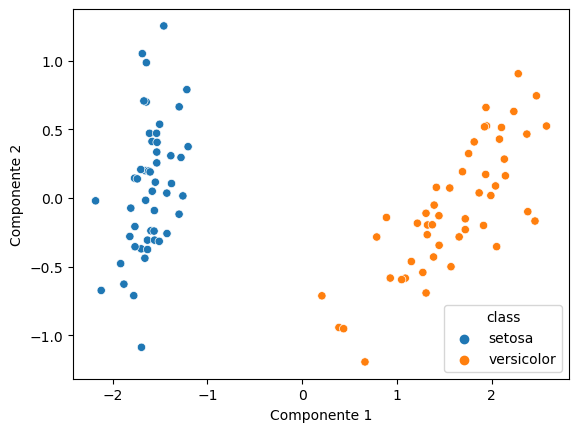

In [351]:
iris = sns.load_dataset('iris')
iris = iris[iris['species'] != 'virginica']
iris_pca = apply_pca(iris, "species")

plot_pca(iris_pca)

In [352]:
iris_treinamento, iris_teste = separar_dados(iris_pca)

In [353]:
try:
    a, b, acima,pontos1, pontos2, p1, p2, classes = cria_modelo(iris_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(iris_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Métricas calculadas:
Precisão:  1.0 
Revocação:  1.0 
F1-score:  1.0


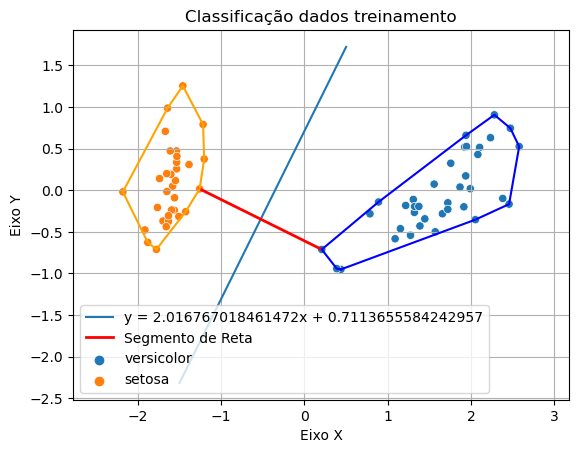

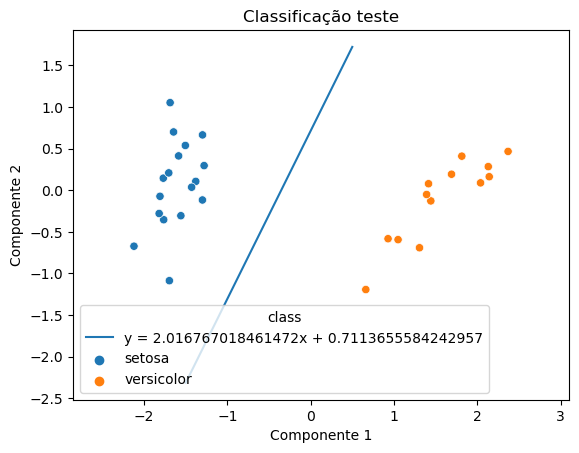

In [354]:
start = -1.5
end = 0.5


plot_treinamento(pontos1, pontos2, p1, p2, a, b, iris_treinamento, start, end)
plot_teste(a, b, iris_teste, start, end)


## Dataset 2: Penguins

Variação total explicada pelos dois primeiros componentes: 100.00%


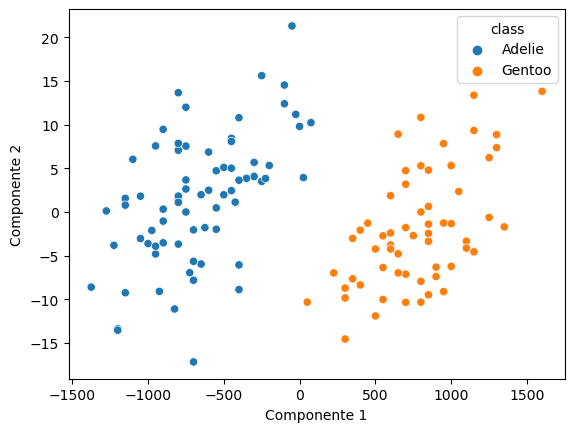

In [355]:
penguins = sns.load_dataset('penguins')
penguins = penguins.dropna()
penguins = penguins[penguins['species'] != 'Chinstrap']
penguins = penguins[penguins['sex'] != 'Female']
penguins_pca = apply_pca(penguins, 'species')

plot_pca(penguins_pca)


In [356]:
penguins_treinamento, penguins_teste = separar_dados(penguins_pca)

In [357]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(penguins_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(penguins_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Métricas calculadas:
Precisão:  1.0 
Revocação:  1.0 
F1-score:  1.0


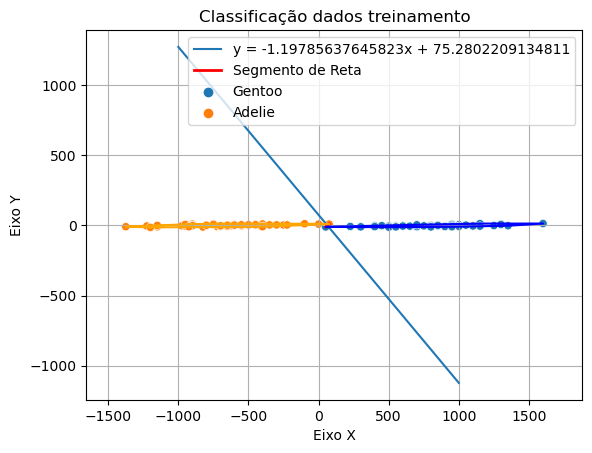

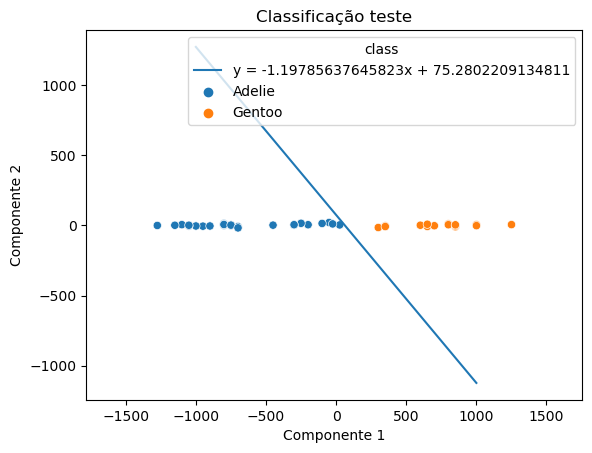

In [358]:
start = -1000
end = 1000

plot_treinamento(pontos1, pontos2, p1, p2, a, b, penguins_treinamento, start, end)

plot_teste(a, b, penguins_teste, start, end)



## Dataset 3: Breast Cancer

Variação total explicada pelos dois primeiros componentes: 99.82%


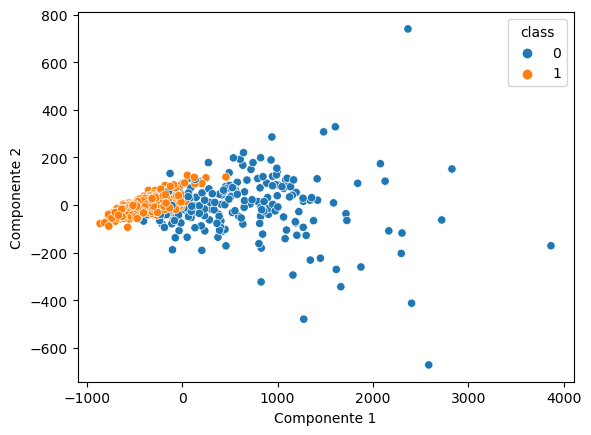

In [359]:
breast_cancer_data = sklearn.datasets.load_breast_cancer()
breast_cancer = pd.DataFrame(breast_cancer_data.data, columns=breast_cancer_data.feature_names)
breast_cancer['target'] = breast_cancer_data.target
breast_pca = apply_pca(breast_cancer, 'target')

plot_pca(breast_pca)

In [360]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(breast_pca)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(breast_pca, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)


Envoltórias se cruzam, não é possível criar o modelo


## DATASET 4: wheat seeds

https://www.kaggle.com/datasets/jmcaro/wheat-seedsuci/data?select=seeds.csv

Variação total explicada pelos dois primeiros componentes: 99.60%


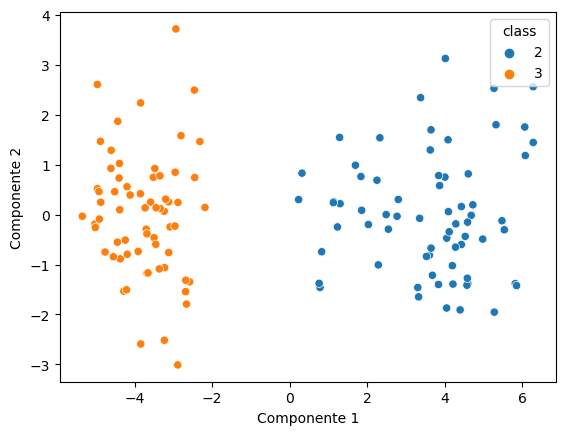

In [361]:
seeds = pd.read_csv('data/seeds.csv')
seeds = seeds[seeds['Type'] != 1]
seeds['Type'] = seeds['Type'].astype(str)
seeds_pca = apply_pca(seeds, 'Type')

plot_pca(seeds_pca)


In [362]:
seeds_treinamento, seeds_teste = separar_dados(seeds_pca)

In [363]:
try:  
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(seeds_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(seeds_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Métricas calculadas:
Precisão:  1.0 
Revocação:  1.0 
F1-score:  1.0


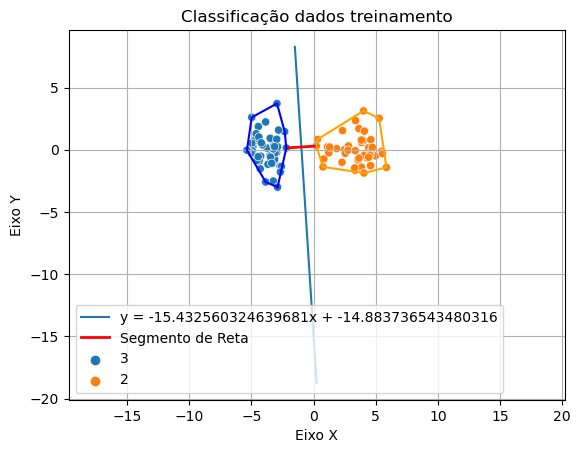

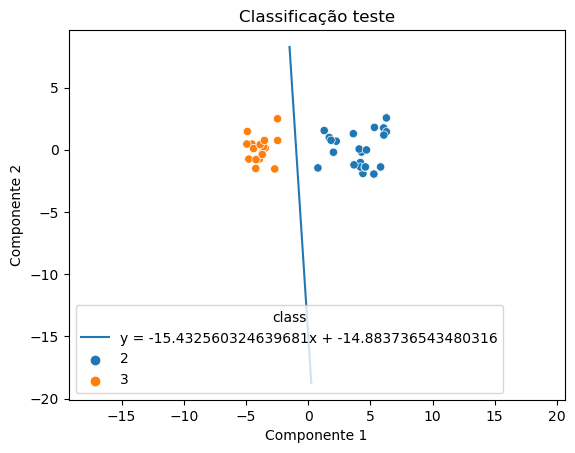

In [364]:
start = -1.5
end = 0.25

plot_treinamento(pontos1, pontos2, p1, p2, a, b, seeds_treinamento, start, end)
plot_teste(a, b, seeds_teste, start, end)

## Dataset 5: zoo 

https://archive.ics.uci.edu/dataset/111/zoo

Variação total explicada pelos dois primeiros componentes: 83.73%


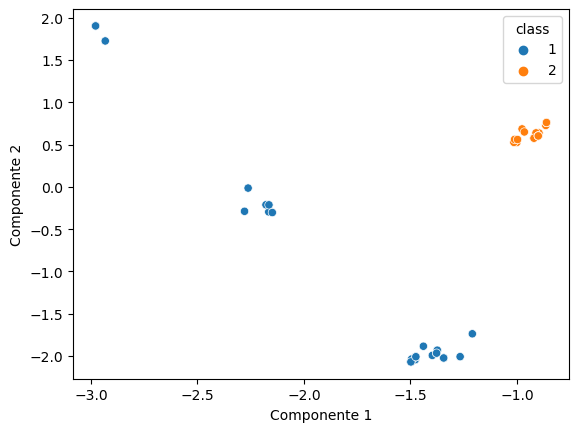

In [365]:
zoo_pca = retorna_pca_uci(111, 'type')
zoo_pca['class'] = zoo_pca['class'].astype(str)
zoo_pca = zoo_pca[(zoo_pca['class'] == '1') |(zoo_pca['class'] == '2')]

plot_pca(zoo_pca)

In [366]:
zoo_treinamento, zoo_teste = separar_dados(zoo_pca)

In [367]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(zoo_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(zoo_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Métricas calculadas:
Precisão:  1.0 
Revocação:  1.0 
F1-score:  1.0


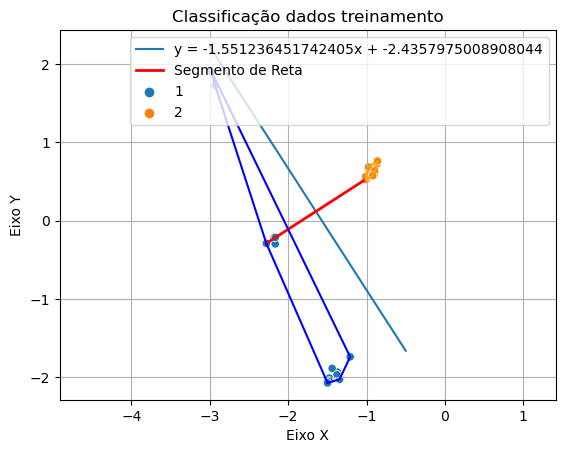

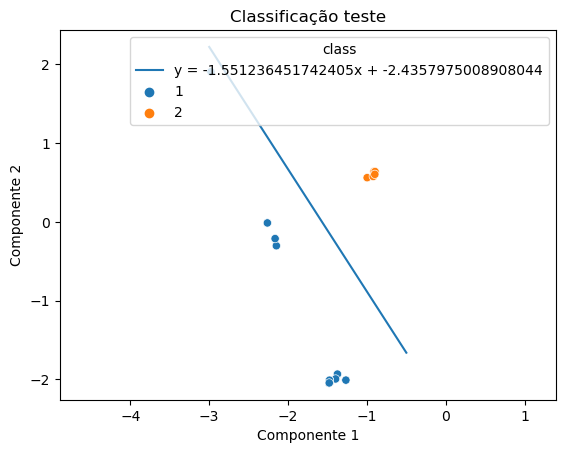

In [368]:
start = -3
end = -0.5


plot_treinamento(pontos1, pontos2, p1, p2, a, b, zoo_treinamento, start, end)
plot_teste(a, b, zoo_teste, start, end)

## DATASET 6: Glass

https://archive.ics.uci.edu/dataset/42/glass+identification

Variação total explicada pelos dois primeiros componentes: 81.08%


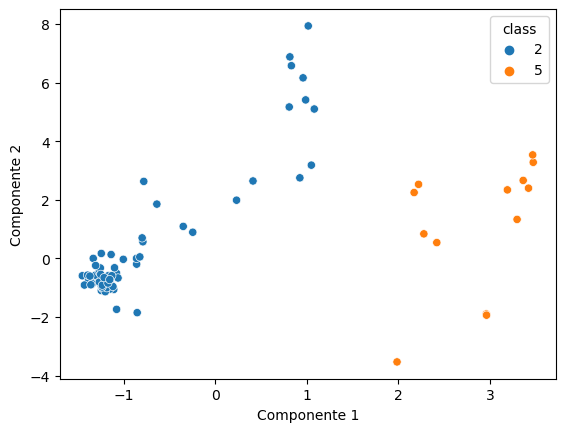

In [369]:
glass_pca = retorna_pca_uci(42, 'Type_of_glass')
glass_pca['class'] = glass_pca['class'].astype(str)
glass_pca = glass_pca[(glass_pca['class'] == '5') | (glass_pca['class'] == '2')]

plot_pca(glass_pca)

In [370]:
glass_treinamento, glass_teste = separar_dados(glass_pca)

In [371]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(glass_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(glass_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Métricas calculadas:
Precisão:  1.0 
Revocação:  0.9583333333333334 
F1-score:  0.9787234042553191


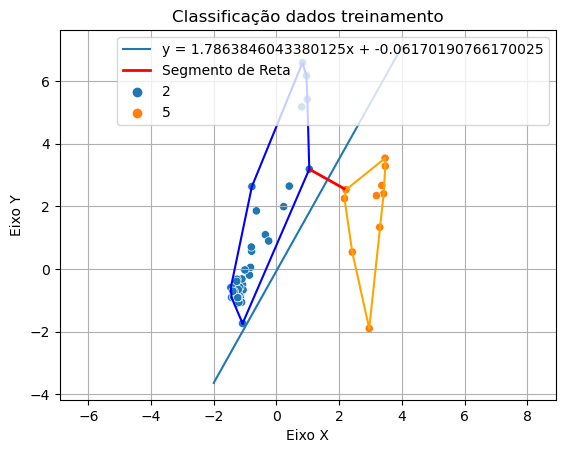

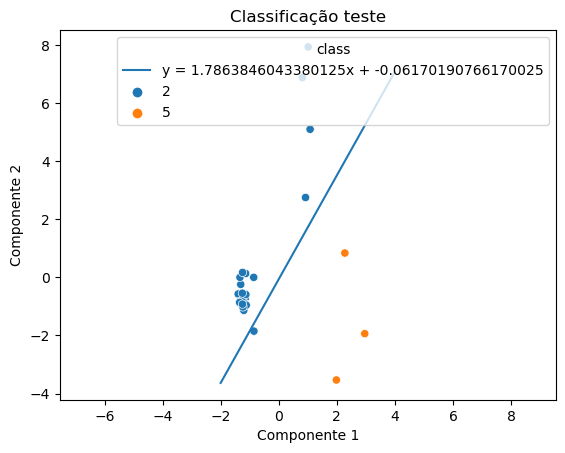

In [372]:
start = -2
end = 4


plot_treinamento(pontos1, pontos2, p1, p2, a, b, glass_treinamento, start, end)
plot_teste(a, b, glass_teste, start, end)

## Dataset 7: Wine


Variação total explicada pelos dois primeiros componentes: 99.98%


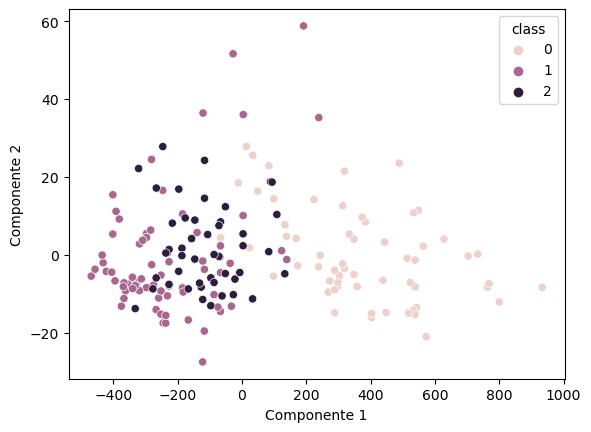

In [373]:
vinho_data = sklearn.datasets.load_wine()
vinho = pd.DataFrame(vinho_data.data, columns=vinho_data.feature_names)
vinho['target'] = vinho_data.target
vinho_pca = apply_pca(vinho, 'target')

plot_pca(vinho_pca)

In [374]:
vinho_treinamento, vinho_teste = separar_dados(vinho_pca)


In [375]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(vinho_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(vinho_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Envoltórias se cruzam, não é possível criar o modelo


## Dataset 8: Heart Disease

Variação total explicada pelos dois primeiros componentes: 89.57%


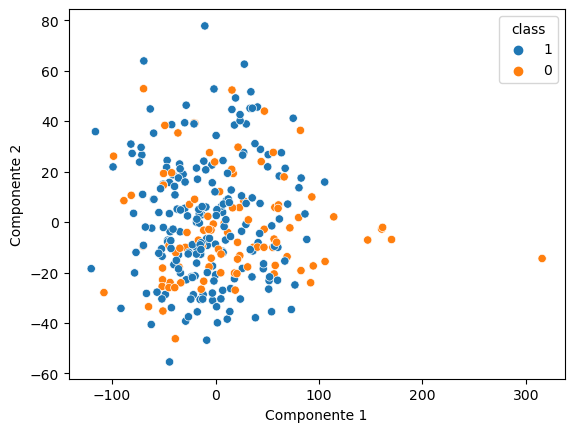

In [376]:
heart_pca = retorna_pca_uci(45, 'sex')
heart_pca['class'] = heart_pca['class'].astype(str)
heart_pca = heart_pca[(heart_pca['class'] == '0') |(heart_pca['class'] == '1')]

plot_pca(heart_pca)


In [377]:
heart_treinamento, heart_teste = separar_dados(heart_pca)

In [378]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(heart_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(heart_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Envoltórias se cruzam, não é possível criar o modelo


## Dataset 9: Census income

Variação total explicada pelos dois primeiros componentes: 100.00%


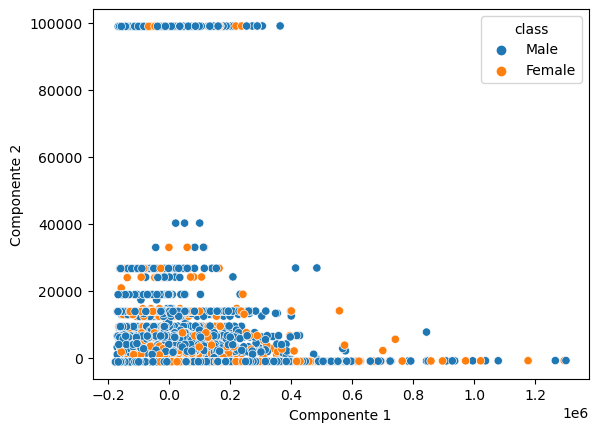

In [379]:
income_pca = retorna_pca_uci(2, 'sex')
income_pca['class'] = income_pca['class'].astype(str)
income_pca = income_pca[(income_pca['class'] == 'Female') |(income_pca['class'] == 'Male')]

plot_pca(income_pca)


In [380]:
income_treinamento, income_teste = separar_dados(income_pca)

In [381]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(income_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(income_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Envoltórias se cruzam, não é possível criar o modelo


## Dataset 10: Automobile

Variação total explicada pelos dois primeiros componentes: 99.87%


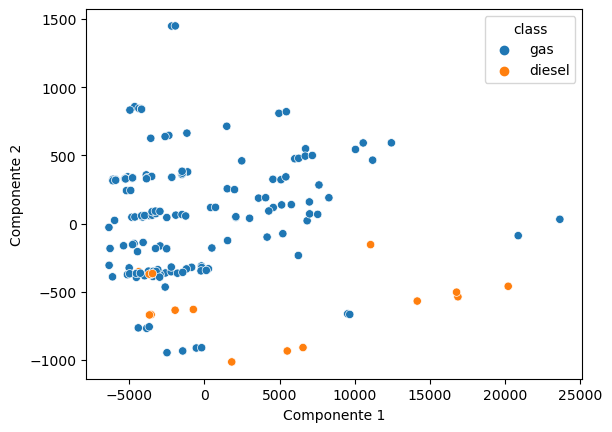

In [382]:
automobile_pca = retorna_pca_uci(10, 'fuel-type')
automobile_pca['class'] = automobile_pca['class'].astype(str)
automobile_pca = automobile_pca[(automobile_pca['class'] == 'diesel') |(automobile_pca['class'] == 'gas')]

plot_pca(automobile_pca)

In [383]:
automobile_treinamento, automobile_teste = separar_dados(automobile_pca)

In [384]:
try:
    a, b, acima, pontos1, pontos2, p1, p2, classes = cria_modelo(automobile_treinamento)
    resultado, precisao, revocacao, f1_escore = calcula_metricas(automobile_teste, a, b, acima, classes)

    print("Métricas calculadas:\nPrecisão: ", precisao, "\nRevocação: ",revocacao,"\nF1-score: ",f1_escore)
except Exception as e:
    print(e)

Envoltórias se cruzam, não é possível criar o modelo
